In [1]:
from utils import load_buffers,load_task_markers
import pandas as pd
import config
import os
import numpy as np

import mne
from mne import create_info
from mne.epochs import EpochsArray
from mne.decoding import Vectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt

import pickle
%matplotlib qt

In [2]:
# Loading files and forming the initial DataFrames
file_path = 'processed_data/motor_imagery/2024-08-10_14-35-49/task_data/task_markers.npz'  # Replace with your file path
df_tasks = load_task_markers(file_path)

folder_path = 'processed_data/motor_imagery/2024-08-10_14-35-49/signal_data/'
df_buffers = load_buffers(folder_path)

df_buffers = df_buffers.sort_values('timestamps').reset_index(drop=True)
df_tasks = df_tasks.sort_values('timestamps').reset_index(drop=True)

# Extracting data for the relevant channels
relevant_channels = 8  # For example, using 8 channels
df_buffers_raw = df_buffers.iloc[:, :relevant_channels] 

# Renaming the columns
channel_names = ['FP1', 'FP2', 'C3', 'C4', 'FC1', 'FC2', 'CP1', 'CP2']
df_buffers_raw.columns = channel_names

# Adding a column with timestamps
df_buffers_raw['timestamps'] = df_buffers['timestamps']

# Displaying the updated DataFrame
df_buffers_raw.head()


Array names in the .npz file: ['event_ids', 'timestamps']


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,155794.437500,-187500.046875,17556.892578,29927.443359,17028.474609,37962.671875,31529.416016,39379.726562,3391.993511
1,155757.890625,-187500.046875,17584.384766,29942.351562,17070.876953,37952.210938,31410.437500,39295.015625,3391.996513
2,155766.062500,-187500.046875,17580.361328,29924.380859,17121.972656,37954.042969,31589.966797,39301.562500,3392.000476
3,155806.515625,-187500.046875,17566.482422,29900.957031,17215.626953,38057.488281,31964.783203,39526.019531,3392.004495
4,155810.875000,-187500.046875,17542.833984,29894.005859,17158.541016,38082.296875,32025.937500,39640.886719,3392.008532


In [3]:
df_markers = df_tasks[df_tasks['event_ids'].isin([1,2,3,4,99,100])]

markers_map = {
            1 :'left_start',
            2: 'left_end',
            3:'right_start',
            4:'right_end',
            99:'rest_start',
            100:'rest_end'
}

# Initialize lists for onsets, durations, and descriptions
onsets = []
durations = []
descriptions = []

# Create a dictionary to keep track of start times
start_times = {}

# Iterate over the DataFrame rows
for index, row in df_markers.iterrows():
    event_id = row['event_ids']
    timestamp = row['timestamps']

    if event_id in markers_map:
        description = markers_map[event_id]

        # Check if it is a start event
        if 'start' in description:
            # Store the start time
            start_times[description.split('_')[0]] = timestamp
        elif 'end' in description:
            # Determine the corresponding start event type
            event_type = description.split('_')[0]  # e.g., 'left', 'right', 'rest'
            
            if event_type in start_times:
                start_time = start_times[event_type]
                duration = timestamp - start_time
                
                # Append to lists
                onsets.append(start_time)
                durations.append(duration)
                descriptions.append(event_type.upper())
                # Remove the start time to avoid re-use
                del start_times[event_type]

# Print the results
print("Onsets:", onsets)
print("Durations:", durations)
print("Descriptions:", descriptions)

Onsets: [3392.2672531, 3395.2895465, 3396.3228873, 3399.3564509, 3400.3897562, 3403.4234834, 3404.4567721, 3407.4901274, 3408.5234687, 3411.5568484, 3412.5901639, 3415.6234959]
Durations: [3.0059383000002526, 1.0174733999997443, 3.017504200000076, 1.017345000000205, 3.0173634999996466, 1.017531500000132, 3.018200800000159, 1.0178539000003184, 3.0178780999999617, 1.0179121999999552, 3.0176485000001776, 1.0174854000001687]
Descriptions: ['LEFT', 'REST', 'RIGHT', 'REST', 'LEFT', 'REST', 'RIGHT', 'REST', 'LEFT', 'REST', 'RIGHT', 'REST']


In [4]:
# Creating separate DataFrames for each event
left_events = []
right_events = []
rest_events = []
# Iterating through onsets, durations, and descriptions, creating a DataFrame for each event
for onset, duration, description in zip(onsets, durations, descriptions):
    event_df = df_buffers_raw[(df_buffers_raw['timestamps'] >= onset) & (df_buffers_raw['timestamps'] <= (onset + duration))]
    
    if description == 'LEFT':
        left_events.append(event_df)
    elif description == 'RIGHT':
        right_events.append(event_df)
    elif description == 'REST':
        rest_events.append(event_df)

# Displaying the first few DataFrames for verification
for i, df in enumerate(left_events[:3]):
    print(f"Left Event {i+1} DataFrame:")
    display(df)

for i, df in enumerate(right_events[:3]):
    print(f"Right Event {i+1} DataFrame:")
    display(df)
    # spectrum = df.compute_psd()

# for i, df in enumerate(rest_events[:3]):
#     print(f"Rest Event {i+1} DataFrame:")
#     display(df)


Left Event 1 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
69,155782.890625,-187500.046875,17513.910156,29840.941406,17164.039062,38050.113281,32023.791016,39612.277344,3392.269182
70,155743.687500,-187500.046875,17535.972656,29881.466797,17031.203125,37941.460938,31553.466797,39377.000000,3392.273132
71,155732.093750,-187500.046875,17565.207031,29904.488281,17063.880859,37920.964844,31374.875000,39259.253906,3392.276126
72,155741.703125,-187500.046875,17553.964844,29882.292969,17113.904297,37923.511719,31532.544922,39266.539062,3392.280146
73,155769.062500,-187500.046875,17528.886719,29845.837891,17191.128906,38000.445312,31879.800781,39456.796875,3392.284172
...,...,...,...,...,...,...,...,...,...
817,155762.421875,-187500.046875,17570.839844,29913.027344,17072.552734,37936.945312,31387.527344,39269.132812,3395.256539
818,155774.062500,-187500.046875,17566.593750,29894.095703,17126.152344,37936.050781,31520.363281,39266.406250,3395.260544
819,155806.390625,-187500.046875,17550.253906,29867.474609,17206.462891,38004.804688,31855.214844,39430.398438,3395.264557
820,155823.468750,-187500.046875,17515.474609,29846.195312,17192.470703,38071.457031,32046.388672,39623.226562,3395.269514


Left Event 2 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
2102,155855.343750,-187500.046875,17473.810547,29824.222656,17133.685547,38039.160156,32008.234375,39581.832031,3400.390192
2103,155815.265625,-187500.046875,17495.515625,29860.052734,16998.970703,37930.082031,31555.656250,39343.832031,3400.394098
2104,155799.593750,-187500.046875,17530.541016,29884.394531,17030.666016,37911.375000,31365.755859,39222.214844,3400.397189
2105,155810.484375,-187500.046875,17522.292969,29864.724609,17082.007812,37915.578125,31517.144531,39238.890625,3400.401191
2106,155838.015625,-187500.046875,17501.818359,29835.980469,17160.865234,37990.703125,31858.478516,39419.582031,3400.406129
...,...,...,...,...,...,...,...,...,...
2853,155915.734375,-187500.046875,17469.027344,29786.449219,17171.482422,38024.742188,32021.689453,39585.007812,3403.390520
2854,155885.734375,-187500.046875,17484.406250,29821.318359,17028.966797,37925.300781,31629.349609,39380.308594,3403.394552
2855,155863.859375,-187500.046875,17518.246094,29849.257812,17035.136719,37886.832031,31354.400391,39228.562500,3403.398488
2856,155873.046875,-187500.046875,17517.486328,29841.099609,17087.998047,37890.074219,31462.449219,39227.042969,3403.401537


Left Event 3 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
4138,156017.703125,-187500.046875,17539.771484,29863.472656,17102.861328,37925.433594,31474.765625,39267.835938,3408.524197
4139,156034.562500,-187500.046875,17517.576172,29837.142578,17167.681641,37968.437500,31763.236328,39395.687500,3408.528117
4140,156068.484375,-187500.046875,17493.906250,29820.177734,17205.054688,38065.890625,32072.316406,39641.242188,3408.533148
4141,156038.000000,-187500.046875,17502.556641,29847.333984,17069.423828,37985.539062,31756.419922,39498.574219,3408.537161
4142,156010.921875,-187500.046875,17540.710938,29883.767578,17050.669922,37931.871094,31415.689453,39310.214844,3408.541155
...,...,...,...,...,...,...,...,...,...
4889,156017.437500,-187500.046875,17503.001953,29844.921875,17051.945312,37911.753906,31415.353516,39260.035156,3411.524543
4890,156029.968750,-187500.046875,17484.271484,29814.500000,17101.878906,37924.160156,31641.486328,39314.015625,3411.529495
4891,156064.031250,-187500.046875,17460.109375,29787.185547,17170.632812,38030.128906,32002.511719,39569.761719,3411.532516
4892,156055.859375,-187500.046875,17452.957031,29799.300781,17062.181641,37993.070312,31852.867188,39536.347656,3411.535566


Right Event 1 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
1084,155785.484375,-187500.046875,17532.105469,29845.568359,17140.748047,37939.894531,31678.591797,39305.878906,3396.323045
1085,155817.281250,-187500.046875,17502.712891,29820.714844,17198.080078,38051.832031,32026.673828,39573.226562,3396.327087
1086,155793.875000,-187500.046875,17496.341797,29837.679688,17063.455078,37984.265625,31785.521484,39481.785156,3396.331108
1087,155761.390625,-187500.046875,17539.705078,29883.052734,17021.501953,37913.320312,31383.369141,39261.800781,3396.335136
1088,155764.687500,-187500.046875,17550.769531,29881.085938,17079.146484,37918.238281,31421.031250,39232.964844,3396.340048
...,...,...,...,...,...,...,...,...,...
1835,155841.859375,-187500.046875,17560.781250,29895.414062,17157.937500,37975.660156,31672.466797,39306.949219,3399.323459
1836,155871.484375,-187500.046875,17532.283203,29866.757812,17229.751953,38087.304688,32035.236328,39568.601562,3399.327426
1837,155855.546875,-187500.046875,17515.429688,29869.888672,17111.289062,38042.156250,31885.433594,39534.246094,3399.331444
1838,155818.218750,-187500.046875,17551.529297,29906.857422,17043.160156,37956.300781,31446.802734,39299.640625,3399.335490


Right Event 2 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
3120,155900.000000,-187500.046875,17499.136719,29841.992188,17009.365234,37884.933594,31403.687500,39275.097656,3404.457088
3121,155899.906250,-187500.046875,17511.652344,29839.533203,17059.298828,37881.511719,31389.248047,39223.578125,3404.461122
3122,155915.062500,-187500.046875,17493.705078,29809.806641,17107.890625,37888.128906,31608.787109,39269.066406,3404.466044
3123,155956.750000,-187500.046875,17468.984375,29783.521484,17181.339844,37997.519531,31973.656250,39529.910156,3404.469057
3124,155943.531250,-187500.046875,17457.271484,29793.490234,17076.710938,37966.359375,31848.351562,39511.917969,3404.472159
...,...,...,...,...,...,...,...,...,...
3871,156013.390625,-187500.046875,17551.953125,29893.693359,17068.708984,37965.621094,31547.945312,39378.363281,3407.457431
3872,155998.437500,-187500.046875,17573.656250,29905.359375,17106.996094,37953.128906,31432.833984,39289.808594,3407.461440
3873,156013.515625,-187500.046875,17561.273438,29882.248047,17153.689453,37951.316406,31608.673828,39306.234375,3407.465477
3874,156043.765625,-187500.046875,17534.832031,29845.904297,17235.005859,38044.816406,31968.248047,39528.300781,3407.469485


Right Event 3 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
5156,156049.687500,-187500.046875,17452.621094,29771.138672,17134.847656,37967.097656,31837.802734,39432.792969,3412.591099
5157,156058.343750,-187500.046875,17427.833984,29759.089844,17109.052734,38018.082031,31988.810547,39599.042969,3412.595108
5158,156024.609375,-187500.046875,17457.517578,29803.882812,16982.318359,37915.800781,31543.541016,39367.414062,3412.600035
5159,156005.656250,-187500.046875,17487.132812,29824.402344,17009.744141,37893.382812,31357.708984,39246.890625,3412.603046
5160,156017.515625,-187500.046875,17480.361328,29803.927734,17060.058594,37890.855469,31502.570312,39248.925781,3412.606111
...,...,...,...,...,...,...,...,...,...
5906,156068.437500,-187500.046875,17490.195312,29806.029297,17083.974609,37885.937500,31478.386719,39265.488281,3415.587429
5907,156094.031250,-187500.046875,17474.638672,29779.072266,17157.824219,37939.226562,31777.876953,39398.503906,3415.591447
5908,156122.906250,-187500.046875,17445.134766,29757.861328,17183.261719,38032.074219,32055.375000,39636.972656,3415.595459
5909,156093.250000,-187500.046875,17448.576172,29784.548828,17039.091797,37937.726562,31693.521484,39461.582031,3415.599509


In [5]:
import mne
import numpy as np
import pandas as pd

# Установка уровня журнала для вывода информации о фильтрации
mne.set_log_level('info')

# Функция для увеличения данных для устранения краевых эффектов
def mirror_padding(data, pad_len):
    return np.concatenate([data[:, pad_len-1::-1], data, data[:, :-pad_len-1:-1]], axis=1)

# Функция для фильтрации DataFrame сигналов ЭЭГ с использованием IIR фильтра и notch-фильтра для удаления сетевого шума с использованием mirror padding
def filter_eeg_data(df, sfreq, low_freq, high_freq, pad_len=256):
    # Создание объекта MNE Info для данных
    info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types='eeg')

    # Преобразование DataFrame в массив NumPy
    raw_data = df[channel_names].to_numpy().T
    timestamps = df['timestamps'].to_numpy()

    # Применение mirror padding к данным
    data_padded = mirror_padding(raw_data, pad_len)

    # Создание RawArray объекта из данных
    raw = mne.io.RawArray(data_padded, info)

    # Применение полосового IIR фильтра
    raw.filter(low_freq, high_freq, method='iir')
    
    # Применение notch-фильтра для удаления сетевого шума на частоте 50 Гц
    raw.notch_filter(freqs=50.0, method='iir')

    # Удаление краевых значений после фильтрации
    filtered_data = raw.get_data()[:, pad_len:-pad_len]

    # Санитизация timestamps для соответствия отфильтрованных данных
    timestamps = timestamps[:filtered_data.shape[1]]

    # Создание DataFrame с отфильтрованными данными
    df_filtered = pd.DataFrame(data=filtered_data.T, columns=channel_names)
    df_filtered['timestamps'] = timestamps

    return df_filtered

# Частота выборки и параметры фильтрации
sfreq = 250  # частота выборки
low_freq = 1.0  # нижняя граница фильтра
high_freq = 40.0  # верхняя граница фильтра

# Применение фильтрации к событиям 'left', 'right', 'rest'
left_events_filtered = [filter_eeg_data(df, sfreq, low_freq, high_freq) for df in left_events]
right_events_filtered = [filter_eeg_data(df, sfreq, low_freq, high_freq) for df in right_events]
rest_events_filtered = [filter_eeg_data(df, sfreq, low_freq, high_freq) for df in rest_events]

# Отображение первых нескольких отфильтрованных DataFrame для верификации
for i, df in enumerate(left_events_filtered[:3]):
    print(f"Filtered Left Event {i+1} DataFrame:")
    display(df)

for i, df in enumerate(right_events_filtered[:3]):
    print(f"Filtered Right Event {i+1} DataFrame:")
    display(df)

for i, df in enumerate(rest_events_filtered[:3]):
    print(f"Filtered Rest Event {i+1} DataFrame:")
    display(df)

Creating RawArray with float64 data, n_channels=8, n_times=1265
    Range : 0 ... 1264 =      0.000 ...     5.056 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB

Creating RawArray with float64 data, n_channels=8, n_times=1268
    Range : 0 ... 1267 =      0.000 ...     5.068 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
-----------

,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,-2.902609,3.413013e-12,-4.725888,2.079062,-24.002780,20.904307,37.402358,59.896619,3392.269182
1,-4.309879,3.302479e-12,-0.910668,2.715628,-11.035701,13.453589,21.051549,30.607757,3392.273132
2,-6.546509,3.191898e-12,3.327879,3.231034,3.833786,2.928400,-4.251554,-8.399156,3392.276126
3,-8.078608,3.081324e-12,4.051255,2.646989,9.428302,-4.069237,-23.333725,-31.116449,3392.280146
4,-7.455694,2.970823e-12,0.740855,1.287766,4.040469,-4.025363,-26.387559,-27.165585,3392.284172
...,...,...,...,...,...,...,...,...,...
748,2.988501,4.035265e-15,2.883088,1.558463,0.742369,-12.527051,-42.869153,-27.789715,3395.256539
749,2.048569,4.046262e-15,3.172377,0.651493,-2.748606,-19.995943,-69.988971,-47.219122,3395.260544
750,7.025612,4.054594e-15,-4.974569,-7.201662,-1.999940,-10.564114,-21.442233,-15.607668,3395.264557
751,15.947632,4.059833e-15,-19.142244,-20.099708,2.165552,10.822549,82.121735,52.105697,3395.269514


Filtered Left Event 2 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,-4.357042,3.413013e-12,-13.041160,5.854310,-41.477314,9.590356,37.355259,58.616179,3400.390192
1,-6.613100,3.302479e-12,-6.522163,7.587426,-28.254260,2.598973,17.803437,28.805497,3400.394098
2,-9.725649,3.191898e-12,1.739038,9.992979,-12.568999,-6.624886,-10.211870,-10.323750,3400.397189
3,-11.645703,3.081324e-12,5.869586,11.289629,-5.645161,-11.580381,-28.027672,-32.310270,3400.401191
4,-11.556317,2.970823e-12,3.921570,10.557972,-10.073399,-9.852310,-26.268118,-27.503671,3400.406129
...,...,...,...,...,...,...,...,...,...
751,17.864659,4.059430e-15,3.074624,-9.972017,8.284281,0.411099,16.263244,20.211063,3403.390520
752,19.529650,4.062088e-15,1.451409,-9.664131,6.500845,3.413197,27.333726,29.685088,3403.394552
753,17.106647,4.062277e-15,6.234763,-4.955315,9.906546,-4.870911,-3.915191,2.539544,3403.398488
754,11.541732,4.059751e-15,15.741980,2.941667,16.218229,-21.405479,-67.482426,-51.183295,3403.401537


Filtered Left Event 3 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,5.544207,3.413013e-12,-1.732569,-20.299638,44.065047,-9.956831,29.674341,-23.098376,3408.524197
1,4.669509,3.302479e-12,-3.375491,-16.515612,26.044214,-8.358691,17.830317,-8.459176,3408.528117
2,3.999491,3.191898e-12,-5.171664,-11.432259,4.262652,-5.455943,6.965749,12.100237,3408.533148
3,3.985587,3.081324e-12,-5.208625,-7.434266,-6.101400,-2.972812,5.043269,24.809170,3408.537161
4,4.042197,2.970823e-12,-3.161525,-5.162055,-1.394083,-2.313068,9.638803,22.991336,3408.541155
...,...,...,...,...,...,...,...,...,...
751,-4.664232,4.059430e-15,1.254847,10.060899,6.870898,7.403485,8.441279,-10.024352,3411.524543
752,-6.588528,4.062088e-15,1.517908,9.686152,6.615264,2.843661,-3.354956,-21.724650,3411.529495
753,-5.387454,4.062277e-15,-2.490087,7.014386,-2.825673,5.203239,6.262241,-6.465062,3411.532516
754,-1.460223,4.059751e-15,-9.552020,2.949650,-17.377779,13.632332,34.984403,29.775529,3411.535566


Filtered Right Event 1 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,15.147206,3.413013e-12,-20.773328,-41.259557,50.969391,22.732948,203.807304,82.005864,3396.323045
1,5.641984,3.302479e-12,-15.008710,-30.609580,24.461300,5.070194,102.946685,39.228476,3396.327087
2,-5.681232,3.191898e-12,-7.417500,-16.532908,-8.759870,-16.315095,-21.899794,-12.813689,3396.331108
3,-10.145965,3.081324e-12,-2.560720,-7.754221,-25.204516,-25.844520,-83.030655,-36.980466,3396.335136
4,-5.405946,2.970823e-12,-2.201740,-7.815817,-17.584758,-19.530474,-55.069959,-23.361838,3396.340048
...,...,...,...,...,...,...,...,...,...
751,5.110512,4.059430e-15,7.340569,10.128299,22.466466,27.307308,78.309873,35.240032,3399.323459
752,7.419621,4.062088e-15,7.036931,7.764153,30.025511,31.075679,100.509976,42.897050,3399.327426
753,1.068870,4.062277e-15,8.570285,10.343567,12.313800,19.654780,40.736774,18.421165,3399.331444
754,-10.585743,4.059751e-15,11.647822,16.922646,-22.674610,-1.516397,-73.674114,-26.506497,3399.335490


Filtered Right Event 2 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,-27.241050,3.413013e-12,21.993466,19.596893,-39.511938,-50.658415,-247.825119,-130.914455,3404.457088
1,-15.695844,3.302479e-12,11.730175,7.017098,-19.154559,-28.615978,-130.115557,-67.997492,3404.461122
2,-0.999499,3.191898e-12,-1.166775,-8.897123,6.818149,-1.135111,17.649082,10.145279,3404.466044
3,7.134348,3.081324e-12,-7.996117,-17.367283,20.268711,12.724442,93.338064,48.959153,3404.469057
4,5.640902,2.970823e-12,-6.096886,-15.001403,15.041420,7.418858,65.452440,32.218381,3404.472159
...,...,...,...,...,...,...,...,...,...
751,-8.907579,4.059430e-15,2.197418,7.618607,-21.270437,-20.816117,-78.989936,-48.670290,3407.457431
752,-12.244134,4.062088e-15,1.816711,7.418520,-29.884100,-28.582603,-106.287535,-64.042419,3407.461440
753,-7.479440,4.062277e-15,-5.835172,-3.120514,-13.898942,-15.193084,-31.300234,-26.977478,3407.465477
754,3.031512,4.059751e-15,-17.727475,-20.282137,19.915673,13.012281,114.257887,45.647507,3407.469485


Filtered Right Event 3 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,17.196688,3.413013e-12,-12.987534,-3.985328,39.311306,61.056379,232.530034,136.299620,3412.591099
1,7.420706,3.302479e-12,-3.062292,7.361646,20.067832,38.439172,124.570672,76.324758,3412.595108
2,-4.926225,3.191898e-12,9.589913,21.649775,-4.381336,10.157230,-10.782319,1.690227,3412.600035
3,-11.450030,3.081324e-12,16.668012,28.900943,-16.671843,-4.019659,-78.288506,-35.115534,3412.603046
4,-9.586553,2.970823e-12,15.587949,25.889408,-11.006672,1.904846,-48.269327,-18.426557,3412.606111
...,...,...,...,...,...,...,...,...,...
750,16.269989,4.054181e-15,5.663787,-10.484129,34.617222,-4.776485,29.434538,8.080332,3415.587429
751,18.938141,4.059585e-15,8.663873,-7.617917,41.807308,-2.235742,32.569159,5.976785,3415.591447
752,19.788189,4.062336e-15,7.234092,-5.106365,29.981782,-1.050759,17.029784,10.920690,3415.595459
753,19.307406,4.062274e-15,2.500906,-3.325657,5.415211,-0.593907,-7.852201,22.447463,3415.599509


Filtered Rest Event 1 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,4.906270,3.413011e-12,-8.053007,-9.411564,-9.653666,5.282158,33.936324,41.974813,3395.289570
1,2.502530,3.302478e-12,1.783710,-3.157312,3.920358,-5.607797,-5.236157,-2.140087,3395.294506
2,1.982546,3.191898e-12,7.246229,1.131965,11.303179,-10.249511,-24.356251,-23.407550,3395.298580
3,3.324656,3.081325e-12,6.378892,2.099201,9.323541,-7.228553,-17.983460,-14.657979,3395.301564
4,4.836015,2.970823e-12,2.542237,0.958000,3.546615,-1.347909,-0.838886,6.047777,3395.305523
...,...,...,...,...,...,...,...,...,...
248,-8.800920,4.513522e-13,-3.997588,-5.484071,-14.271474,-12.676265,-31.045407,-22.687191,3396.280033
249,-6.134570,4.435167e-13,-9.899581,-10.964445,-11.822962,-1.298953,17.150536,11.864855,3396.284073
250,-5.779505,4.355503e-13,-12.949495,-13.807183,-12.328087,1.598216,36.187380,25.626651,3396.287086
251,-11.909032,4.274372e-13,-8.366573,-10.627369,-19.070994,-14.804676,-17.891806,-13.176166,3396.291056


Filtered Rest Event 2 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,8.044622,3.413011e-12,28.187207,24.754008,34.634155,16.173338,2.754717,-12.729338,3399.359451
1,13.455685,3.302478e-12,21.557942,22.374271,20.177699,25.697632,31.397213,24.243381,3399.363487
2,15.981962,3.191898e-12,17.335970,20.362500,11.448208,28.818572,42.751556,40.393291,3399.367418
3,14.089768,3.081325e-12,16.438277,18.579005,11.364709,23.882982,33.294488,29.554135,3399.372405
4,9.467621,2.970823e-12,16.557302,16.218100,14.487866,15.643706,16.329810,8.498988,3399.376437
...,...,...,...,...,...,...,...,...,...
248,-2.692779,4.513522e-13,-14.398212,-9.625681,-12.776285,-5.716513,9.365502,6.035713,3400.350136
249,-8.295690,4.435167e-13,-9.310569,-4.977620,-15.205041,-15.917058,-39.640365,-26.360644,3400.354148
250,-11.101802,4.355503e-13,-6.238022,-2.415605,-16.496749,-19.771335,-61.597324,-40.914831,3400.360140
251,-7.072007,4.274372e-13,-9.858563,-5.858791,-14.628372,-8.488819,-13.244850,-8.861723,3400.363149


Filtered Rest Event 3 DataFrame:


,FP1,FP2,C3,C4,FC1,FC2,CP1,CP2,timestamps
0,-11.227210,3.413014e-12,-4.197348,-8.244912,-7.165204,-9.940736,-11.955867,-4.812909,3403.426500
1,-16.828540,3.302479e-12,-1.110438,-3.249525,-25.018102,-26.421748,-85.160377,-42.646770,3403.429541
2,-13.570988,3.191896e-12,-3.876599,-5.641871,-19.844163,-20.867315,-58.486550,-29.185855,3403.433562
3,-6.117590,3.081322e-12,-8.431675,-10.531240,-3.257381,-5.006663,11.397417,6.127239,3403.438507
4,-1.258950,2.970823e-12,-9.543935,-11.410737,6.226503,3.855379,42.990930,21.796577,3403.442520
...,...,...,...,...,...,...,...,...,...
245,5.728386,4.740007e-13,-2.887593,-12.136089,1.077569,-12.741270,0.901841,10.305582,3404.405105
246,5.632847,4.666183e-13,-3.893094,-16.797697,2.389849,-18.385659,-5.818951,-3.189095,3404.409102
247,4.471567,4.590805e-13,-2.451130,-19.464967,5.524974,-27.389963,-26.438534,-29.522477,3404.414056
248,4.042196,4.513767e-13,-2.287724,-20.568124,3.496254,-32.836064,-41.543390,-43.771191,3404.417083


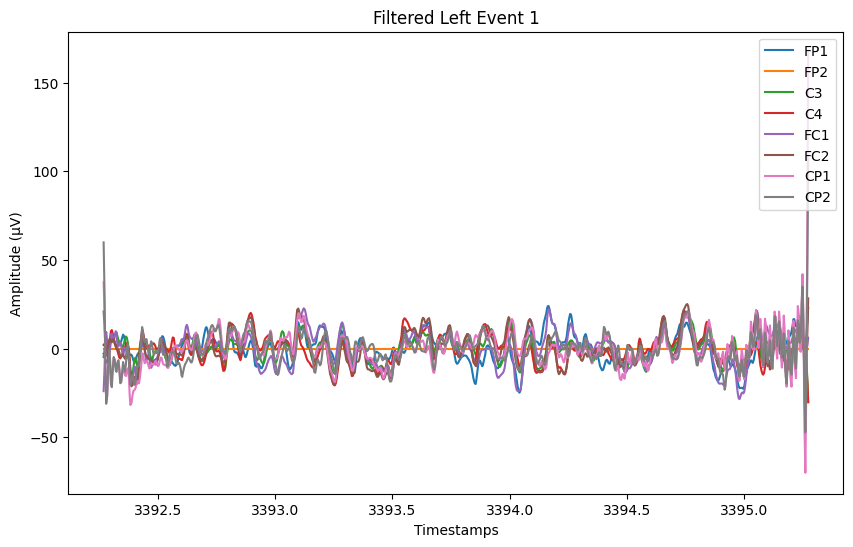

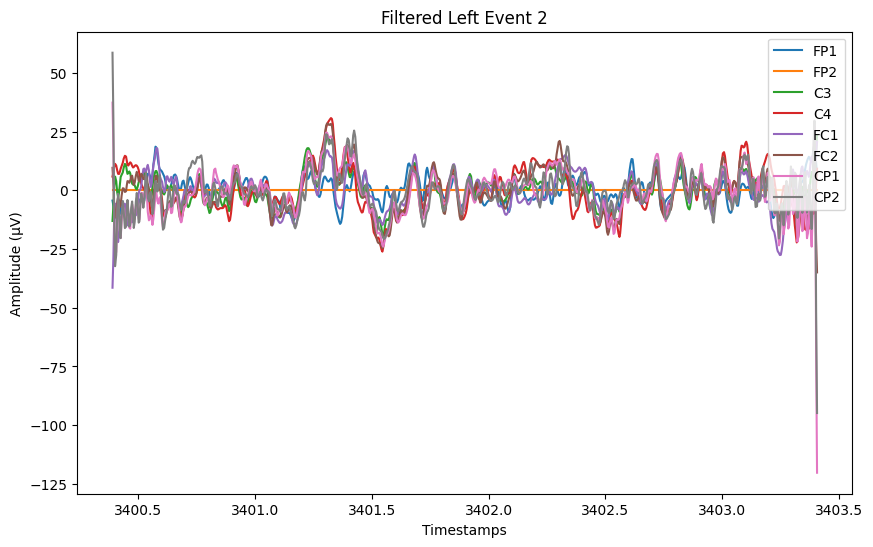

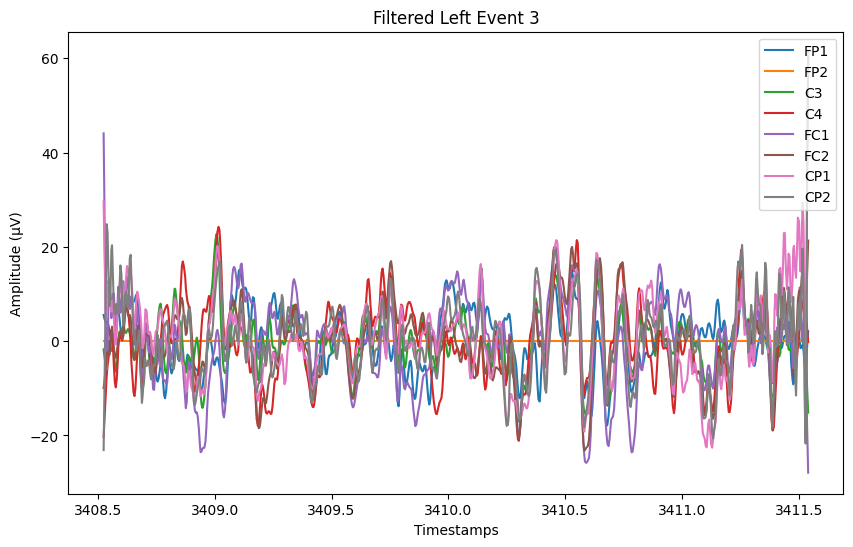

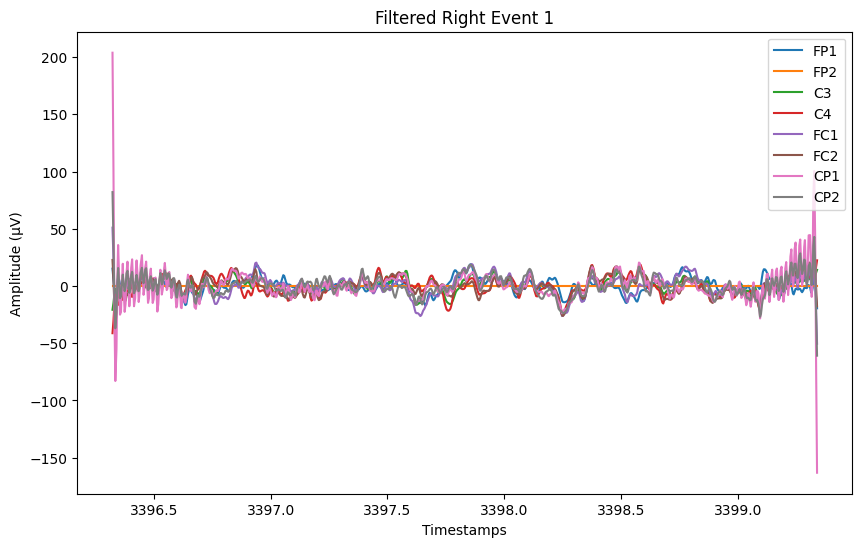

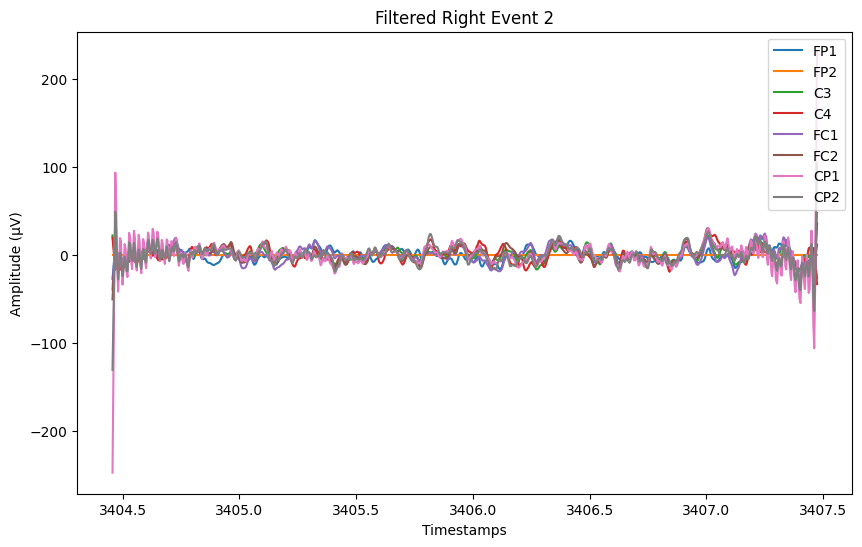

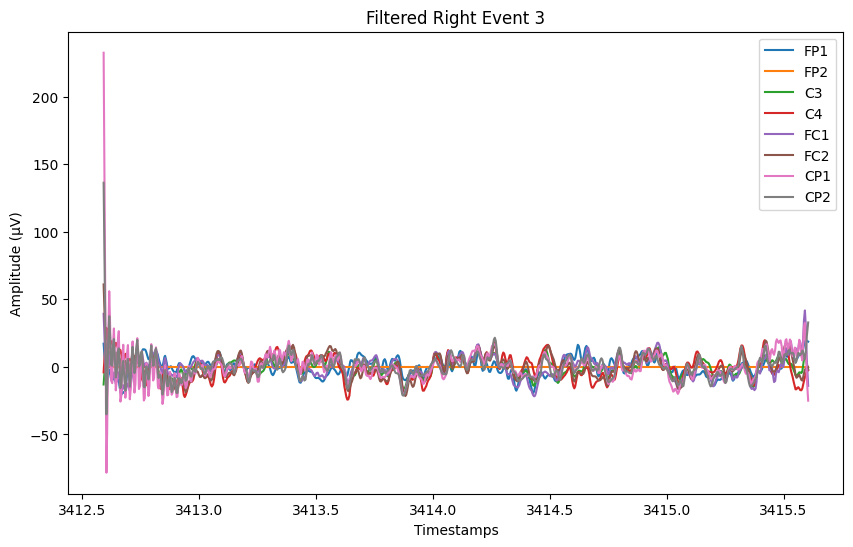

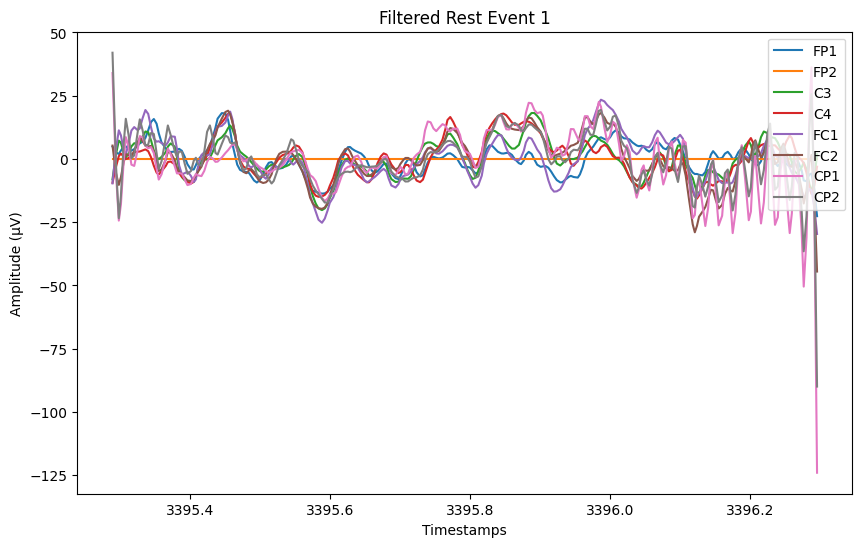

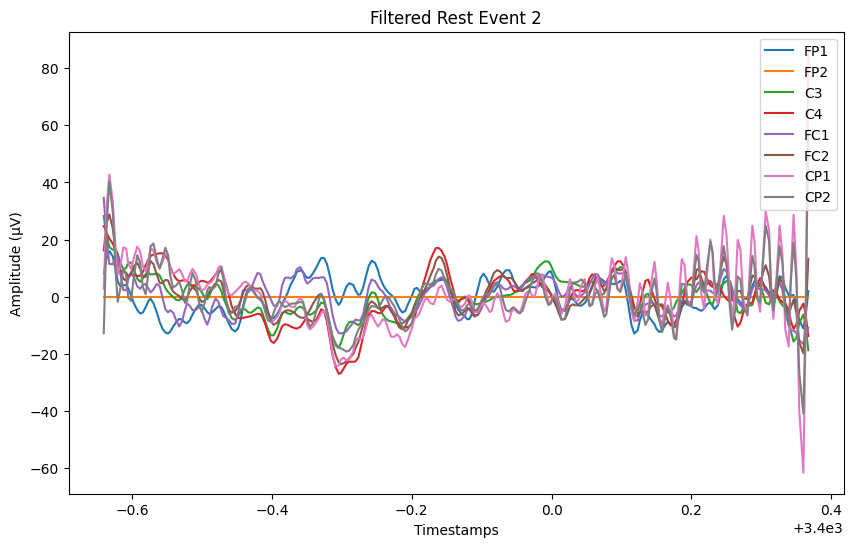

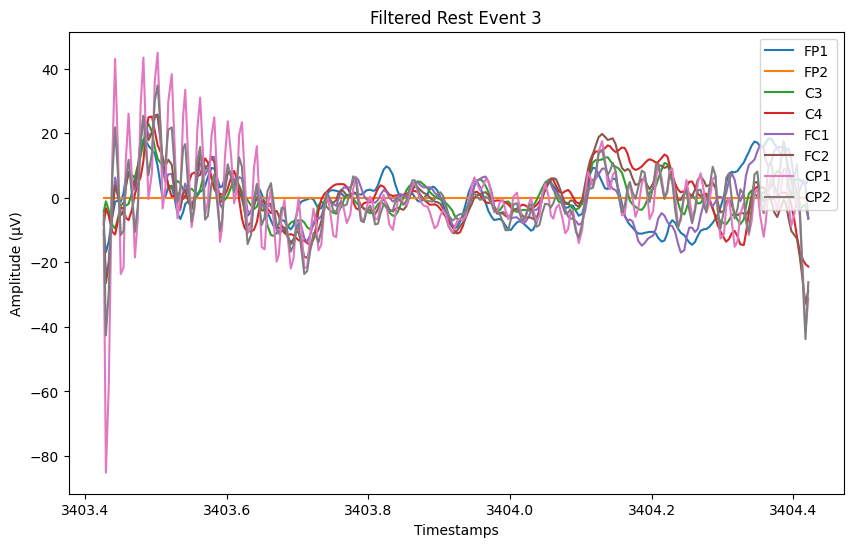

In [13]:
import matplotlib.pyplot as plt

# Включение отображения графиков в Jupyter Notebook
%matplotlib inline

# Функция для отрисовки данных ЭЭГ
def plot_eeg_data(df, title):
    plt.figure(figsize=(10, 6))  # Уменьшение размера графика
    for channel in channel_names:
        plt.plot(df['timestamps'], df[channel], label=channel)
    plt.xlabel('Timestamps')
    plt.ylabel('Amplitude (μV)')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

# Отрисовка первых нескольких отфильтрованных DataFrame для верификации и рисование графиков
for i, df in enumerate(left_events_filtered[:3]):
    plot_eeg_data(df, title=f"Filtered Left Event {i+1}")

for i, df in enumerate(right_events_filtered[:3]):
    plot_eeg_data(df, title=f"Filtered Right Event {i+1}")

for i, df in enumerate(rest_events_filtered[:3]):
    plot_eeg_data(df, title=f"Filtered Rest Event {i+1}")

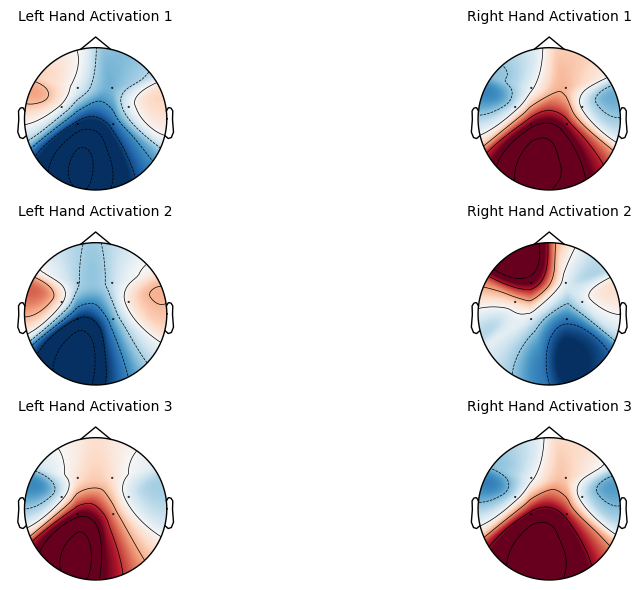

In [7]:
import matplotlib.pyplot as plt
import mne
import numpy as np

# Включение отображения графиков в Jupyter Notebook
%matplotlib inline

# Обновленный список каналов (удалены FP1 и FP2)
channel_names_subset = ['C3', 'C4', 'FC1', 'FC2', 'CP1', 'CP2']

# Создание индивидуального монтажа
montage = mne.channels.make_standard_montage('standard_1020')

# Функция для визуализации топографии ЭЭГ сигналов
def plot_topomap(data, title, sfreq=250):
    info = mne.create_info(ch_names=channel_names_subset, sfreq=sfreq, ch_types='eeg')
    evoked = mne.EvokedArray(data, info)
    evoked.set_montage(montage)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))
    mne.viz.plot_topomap(evoked.data.mean(axis=1), evoked.info, axes=ax, show=True, cmap='RdBu_r')
    ax.set_title(title, fontsize=10)
    plt.show()

# Количество событий
num_events = min(len(left_events_filtered), len(right_events_filtered))

# Визуализация топографии сигналов для событий левой и правой руки
fig, axes = plt.subplots(num_events, 2, figsize=(12, num_events * 2))

for i in range(num_events):
    # Левые события
    data_left = left_events_filtered[i][channel_names_subset].to_numpy().T
    info_left = mne.create_info(ch_names=channel_names_subset, sfreq=250, ch_types='eeg')
    evoked_left = mne.EvokedArray(data_left, info_left)
    evoked_left.set_montage(montage)
    mne.viz.plot_topomap(evoked_left.data.mean(axis=1), evoked_left.info, axes=axes[i, 0], show=False, cmap='RdBu_r')
    axes[i, 0].set_title(f'Left Hand Activation {i+1}', fontsize=10)

    # Правые события
    data_right = right_events_filtered[i][channel_names_subset].to_numpy().T
    info_right = mne.create_info(ch_names=channel_names_subset, sfreq=250, ch_types='eeg')
    evoked_right = mne.EvokedArray(data_right, info_right)
    evoked_right.set_montage(montage)
    mne.viz.plot_topomap(evoked_right.data.mean(axis=1), evoked_right.info, axes=axes[i, 1], show=False, cmap='RdBu_r')
    axes[i, 1].set_title(f'Right Hand Activation {i+1}', fontsize=10)

plt.tight_layout()
plt.show()

In [16]:
import os

# Specify the directory where you want to save the files
output_dir = 'D:/NEvol/filtered_events/'
os.makedirs(output_dir, exist_ok=True)

# Save filtered left events
for i, df in enumerate(left_events_filtered):
    df.drop(columns=['FP1', 'FP2'], inplace=True, errors='ignore')
    df.to_csv(os.path.join(output_dir, f'filtered_left_event_{i+1}.csv'), index=False)

# Save filtered right events
for i, df in enumerate(right_events_filtered):
    df.drop(columns=['FP1', 'FP2'], inplace=True, errors='ignore')
    df.to_csv(os.path.join(output_dir, f'filtered_right_event_{i+1}.csv'), index=False)

print("Filtered events have been saved successfully.")

Filtered events have been saved successfully.
